mapping horizons for eigsep

In [ ]:
import numpy as np
import matplotlib.pylab as plt
from eigsep_terrain.marjum_dem import MarjumDEM as DEM
import eigsep_terrain as et
import eigsep_terrain.utils as etu
import tqdm
import healpy
from scipy.linalg import lstsq
from image_class import Image


In [ ]:
CACHE_FILE = 'marjum_dem.npz'
dem = DEM(cache_file=CACHE_FILE)

In [ ]:
# load image data
img0 = Image(pathname='/Users/komalkaur/Desktop/eigsep_stuff/horizon_mapping/crosshair-imgs/IMG_0765.PNG', 
            label='img0', lat=39.247880, lon=-113.402623, alt=1698.0, heading=88,
            angle_up=84.6, ver_weight=1/4, hor_weight=1/16, dis_weight=23*47)

img1 = Image(pathname='/Users/komalkaur/Desktop/eigsep_stuff/horizon_mapping/crosshair-imgs/IMG_0771.PNG', 
            label='img1', lat=39.247441, lon=-113.402693, alt=1659.0, heading=358,
            angle_up=49.0, ver_weight=1/24, hor_weight=1/8, dis_weight=13*14)

img2 = Image(pathname='/Users/komalkaur/Desktop/eigsep_stuff/horizon_mapping/crosshair-imgs/IMG_0773.PNG', 
            label='img2', lat=39.247484, lon=-113.402730, alt=1695.0, heading=352,
            angle_up=50, ver_weight=1/7, hor_weight=1/22, dis_weight=12*16)

img3 = Image(pathname='/Users/komalkaur/Desktop/eigsep_stuff/horizon_mapping/crosshair-imgs/IMG_0785.PNG', 
            label='img3', lat=39.247797, lon=-113.402905, alt=1713.0, heading=166,
            angle_up=84.8, ver_weight=1/32, hor_weight=1/6, dis_weight=11*10)

img4 = Image(pathname='/Users/komalkaur/Desktop/eigsep_stuff/horizon_mapping/crosshair-imgs/IMG_0787.PNG', 
            label='img4', lat=39.247566, lon=-113.402991, alt=1746.0, heading=150,
            angle_up=85.0, ver_weight=1/11, hor_weight=1/57, dis_weight=9*13)

img5 = Image(pathname='/Users/komalkaur/Desktop/eigsep_stuff/horizon_mapping/crosshair-imgs/IMG_0820.PNG', 
            label='img5', lat=39.248385, lon=-113.401491, alt=1761.0, heading=236,
            angle_up=13.0, ver_weight=1/7, hor_weight=1/5, dis_weight=4*6)

img6 = Image(pathname='/Users/komalkaur/Desktop/eigsep_stuff/horizon_mapping/crosshair-imgs/IMG_0886.PNG', 
            label='img6', lat=39.248631, lon=-113.404227, alt=1834.0, heading=133,
            angle_up=-17.3, ver_weight=1/15, hor_weight=1/9, dis_weight=9*10)

img7 = Image(pathname='/Users/komalkaur/Desktop/eigsep_stuff/horizon_mapping/crosshair-imgs/IMG_0825.PNG', 
            label='img7', lat=39.248400, lon=-113.401572, alt=1759.0, heading=240,
            angle_up=17.4, ver_weight=1/18, hor_weight=1/8, dis_weight=6*7)


In [ ]:
# enus for each photo TODO: is up the same as alt??
enu0 = dem.latlon_to_enu(img0.lat, img0.lon, img0.alt)
enu1 = dem.latlon_to_enu(img1.lat, img1.lon, img1.alt)
enu2 = dem.latlon_to_enu(img2.lat, img2.lon, img2.alt)
enu3 = dem.latlon_to_enu(img3.lat, img3.lon, img3.alt)
enu4 = dem.latlon_to_enu(img4.lat, img4.lon, img4.alt)
enu5 = dem.latlon_to_enu(img5.lat, img5.lon, img5.alt)
enu6 = dem.latlon_to_enu(img6.lat, img6.lon, img6.alt)
enu7 = dem.latlon_to_enu(img7.lat, img7.lon, img7.alt)
enus = [enu0, enu1, enu2, enu3, enu4, enu5, enu6, enu7]
imgs = [img0, img1, img2, img3, img4, img5, img6, img7]


In [ ]:
# ploting functions

def color_str2tup(s):
    r, g, b = s[0:2], s[2:4], s[4:6]
    return tuple(map(lambda x: int(x, base=16) / 255, (r, g, b)))

def plot_img(ax, data, res=dem.res, xlabel=True, ylabel=True,
             colorbar=False, cmap='terrain', erng=None, nrng=None, **kw):
    '''Plot maps with standard format.'''
    if nrng is None:
        nrng = (0, data.shape[0] * res)
    if erng is None:
        erng = (0, data.shape[1] * res)
    extent = erng + nrng
    im = ax.imshow(data, extent=extent, cmap=cmap, origin='lower', interpolation='nearest', **kw)
    if colorbar:
        plt.colorbar(im)
    if xlabel:
        ax.set_xlabel('East [m]')
    if ylabel:
        ax.set_ylabel('North [m]')

def hrzn_angle_plotter(idx):
    '''plot horizon angles for a given enu idx'''
    # calculate horizon angles
    horizon_angles = []
    horizon_pnts = []
    pnt = enus[idx]
    delta_h = 0 #m
    _pnt = pnt + np.array([0, 0, delta_h])
    horizon_angles, horizon_pnts = dem.calc_horizon(*_pnt, n_az=512)

    # plot horizon angles
    fig, ax = plt.subplots()
    plot_img(ax, dem.data, dem.res)
    # for k in horizon_angles: # type: ignore
        # color = ax._get_lines.get_next_color()
    plt.plot(horizon_pnts[1], horizon_pnts[0], '.-') # type: ignore
    plt.plot([enus[idx][0]], [enus[idx][1]], '+')
    _ = plt.title(f'Horizon Points for img{idx}')

    return horizon_pnts, horizon_angles


In [ ]:
# calibrating angles and pixels using img5
pnts, angles = hrzn_angle_plotter(5)


In [ ]:
# find the edge of the canyon using jump in radius
norths = pnts[0] - enus[5][1] # type: ignore
easts = pnts[1] - enus[5][0] # type: ignore

# az_ = np.arctan2(easts, norths)

# rads = np.sqrt(easts**2 + norths**2)
# fig, ax = plt.subplots()
# # ax.scatter(np.rad2deg(az_), rads)
# # ax.scatter(easts, norths)
# # ax.plot(0,0, 'x')

# ax.plot(np.arange(512)*360/512, angles) # azimuth vs angle up to horizon

# ax.set_xlim(-130, -120)


plot above has a horizon shape that does not match the corresponding photo.

trying to correct enus to see if that fixes horizon shape (brute-force approach)

In [ ]:
# # find variation in enu to match horizon shape with photo
# def hrzn_angle_finder(idx, delta_east, delta_north, delta_up):
#     '''plot horizon angles for a given enu idx'''
#     # calculate horizon angles
#     horizon_angles = []
#     horizon_pnts = []
#     center = imgs[idx].heading
#     pnt0 = enus[idx]
#     pnt = enus[idx] + [delta_east, delta_north, delta_up]
#     horizon_angles, horizon_pnts = dem.calc_horizon(*pnt, n_az=512)
#     horizon_angles0, horizon_pnts0 = dem.calc_horizon(*pnt0, n_az=512)
#     fig, ax = plt.subplots()


#     ax.vlines([center-69/2, center, center+69/2, center-60, center+60], 0, 1, color='lightgreen', linestyles='dashed')

#     ax.plot(np.arange(512)*360/512, horizon_angles0, color='lightsteelblue', 
#             label=f'original enu \neast: {np.round(pnt0[0])} \nnorth: {np.round(pnt0[1])}')               
   
#     ax.plot(np.arange(512)*360/512, horizon_angles, color = 'deeppink', 
#             label=f'east: {np.round(pnt[0])} (delta: {delta_east}) \nup: {np.round(pnt[2])} (delta: {delta_up}) \nnorth: {np.round(pnt[1])} (delta: {delta_north})')
    
#     plt.legend(loc='best')
#     plt.show()

# #     return horizon_angles, horizon_pnts


getting indices for canyon features to calibrate with


In [ ]:
# # check which side of the dip is the correct point to calibrate with
# fig, ax = plt.subplots()
# plot_img(ax, dem.data, dem.res)
# plt.plot(easts[325:350], norths[325:350], '.-') # type: ignore
# plt.plot([enus[5][0]], [enus[5][1]], '+')
# _ = plt.title(f'isolating calibration points for img{5}: canyon feature')

In [ ]:
# # narrow down to exact index of canyon feature to calibrate to, guessing around 335
# print(rads[335:338], angles[335:338])  # shows the jump is between index 335 and 336, gonna use 336

# cal_idx = 336
# cal_rad = rads[cal_idx]
# cal_angle = angles[cal_idx] # radians
# cal_east = easts[cal_idx]
# cal_north = norths[cal_idx]


In [ ]:
# # find the 0 of crosshair on the canyon: intersection of trajectory and canyon line
# fig, ax = plt.subplots()
# plot_img(ax, dem.data, dem.res)
# enu_idx = 5
# az = np.deg2rad(imgs[enu_idx].heading)  # type: ignore
# pitch = np.deg2rad(imgs[enu_idx].angle_up)  # type: ignore
# r = np.linspace(0, 300, len(easts))
# e = r * np.sin(az) * np.cos(pitch) + enus[enu_idx][0]
# n = r * np.cos(az) * np.cos(pitch) + enus[enu_idx][1]
# ax.plot(easts[325:350], norths[325:350], '.-')
# line, = ax.plot([enus[enu_idx][0]], [enus[enu_idx][1]], '+', label='aaron')
# ax.plot(e, n, color=line.get_color(), alpha=0.7, label='crosshair trajectory')


# ax.set_xlim(1500-250, 2500-250)
# ax.set_ylim(1500, 2500)
# plt.legend(loc="best")


applying indices to find a calibration from pixels to angles

In [ ]:
# # find where horizon and crosshair intersect
# cross_idx = 335
# cross_east = easts[cross_idx]
# cross_north = norths[cross_idx]
# cross_angle = angles[cross_idx] # radians


In [ ]:
# # angles for calibration
# angle_diff = cal_angle - cross_angle    # radians
# pixel_diff = 56
# pix_per_angle = pixel_diff/angle_diff
# angle_per_pix = angle_diff/pixel_diff


calibrating in the lab

In [ ]:
angle_diff = 2 * np.arctan(4/38)
angle_diff2 = 2 * np.arctan(4.5/30)

pixel_diff = 200
pixel_diff2 = 175

angle_per_pix = angle_diff / pixel_diff
angle_per_pix2 = angle_diff2 / pixel_diff2

angle_per_pix = np.mean((angle_per_pix, angle_per_pix2))


correcting each trajectory

In [ ]:
# all photos and trajectories on canyon prior to angle calibration
fig, ax = plt.subplots()
plot_img(ax, dem.data, dem.res)
for enu_idx in range(len(enus)):
    az = np.deg2rad(imgs[enu_idx].heading)  # type: ignore
    pitch = np.deg2rad(imgs[enu_idx].angle_up)  # type: ignore
    r = np.array([0, 300])
    easts = r * np.sin(az) * np.cos(pitch) + enus[enu_idx][0]
    norths = r * np.cos(az) * np.cos(pitch) + enus[enu_idx][1]

    line, = ax.plot([enus[enu_idx][0]], [enus[enu_idx][1]], '+', label=enu_idx)
    ax.plot(easts, norths, color=line.get_color(), alpha=0.7)


ax.set_xlim(1500-250, 2500-250)
ax.set_ylim(1500, 2500)
plt.legend(loc="best")


calibrate the lines
- find the distance from the vertical crosshair bar (1/img.hor_weight) and convert to angles
- decide for each photo to add/subtract this angle from the trajectory
- plot them all again

In [ ]:
# corrections: positive means antenna was to the left of the crosshair (adding angle ccw)
corrs = np.zeros(8)

for idx in range(len(imgs)):
    corrs[idx] = (1 / imgs[idx].hor_weight) * angle_per_pix * -1  #type: ignore



In [ ]:
# all photos and trajectories on canyon after angle calibration
fig, ax = plt.subplots()
plot_img(ax, dem.data, dem.res)
for enu_idx in range(len(enus)):
    az = np.deg2rad(imgs[enu_idx].heading) + corrs[enu_idx]  # type: ignore
    pitch = np.deg2rad(imgs[enu_idx].angle_up)  # type: ignore
    r = np.array([0, 300])
    easts = r * np.sin(az) * np.cos(pitch) + enus[enu_idx][0]
    norths = r * np.cos(az) * np.cos(pitch) + enus[enu_idx][1]

    line, = ax.plot([enus[enu_idx][0]], [enus[enu_idx][1]], '+', label=enu_idx)
    ax.plot(easts, norths, color=line.get_color(), alpha=0.7)

ax.set_title('after angle correction')
ax.set_xlim(1500-250, 2500-250)
ax.set_ylim(1500, 2500)
plt.legend(loc="best")


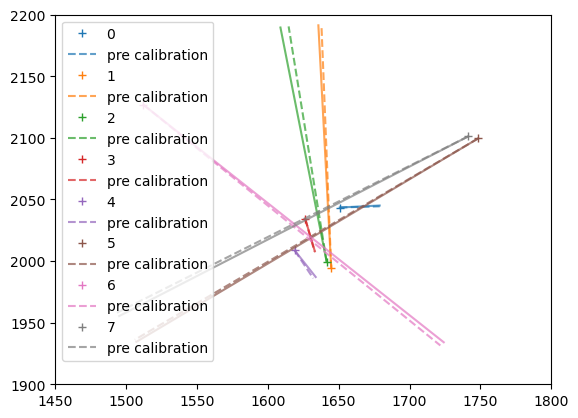

In [358]:
# all photos and trajectories on canyon after angle calibration
fig, ax = plt.subplots()
# plot_img(ax, dem.data, dem.res)
corrected_easts = [0,0,0,0,0,0,0,0]  # array to store the corrected easts
corrected_norths = [0,0,0,0,0,0,0,0]  # array to store the corrected norths
corrected_ups = [0,0,0,0,0,0,0,0]  # array to store the corrected ups

for enu_idx in range(len(enus)):
    az = np.deg2rad(imgs[enu_idx].heading)  # type: ignore
    az_corr = np.deg2rad(imgs[enu_idx].heading) + corrs[enu_idx]  # type: ignore
    pitch = np.deg2rad(imgs[enu_idx].angle_up)  # type: ignore
    r = np.array([0, 300])
    easts = r * np.sin(az) * np.cos(pitch) + enus[enu_idx][0]
    easts_corr = r * np.sin(az_corr) * np.cos(pitch) + enus[enu_idx][0]
    norths = r * np.cos(az) * np.cos(pitch) + enus[enu_idx][1]
    norths_corr = r * np.cos(az_corr) * np.cos(pitch) + enus[enu_idx][1]

    corrected_easts[enu_idx] = easts_corr
    corrected_norths[enu_idx] = norths_corr
    corrected_ups[enu_idx] = r * np.sin(pitch)

    line, = ax.plot([enus[enu_idx][0]], [enus[enu_idx][1]], '+', label=enu_idx)
    ax.plot(easts_corr, norths_corr, color=line.get_color(), alpha=0.7)
    ax.plot(easts, norths, color=line.get_color(), alpha=0.7, linestyle='dashed', label='pre calibration')

ax.set_xlim(1450, 1800)
ax.set_ylim(1900, 2200)
plt.legend(loc="best")

finding where the lines kind of would intersect (not using weighting since the lines were calibrated)

mean of corrected trajectories. not good since the ray length was arbitrary? can use this as a prior for least squares

In [359]:
# rough approx: mean
mean_east = np.mean(corrected_easts)
mean_north = np.mean(corrected_norths)
mean_up = np.mean(corrected_ups)


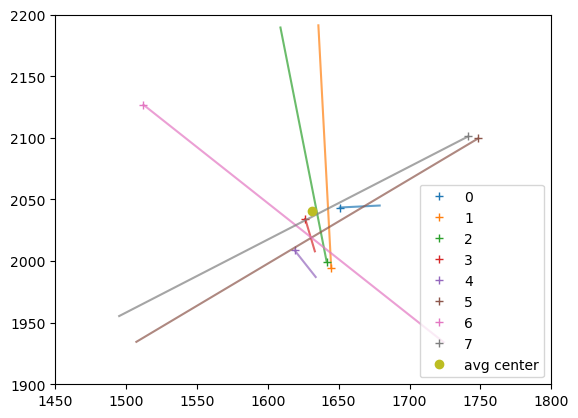

In [360]:
# all photos and trajectories on canyon after angle calibration with mean center
fig, ax = plt.subplots()
# plot_img(ax, dem.data, dem.res)

for enu_idx in range(len(enus)):
    line, = ax.plot([enus[enu_idx][0]], [enus[enu_idx][1]], '+', label=enu_idx)
    ax.plot(corrected_easts[enu_idx], corrected_norths[enu_idx], color=line.get_color(), alpha=0.7)
ax.plot(mean_east, mean_north, 'o', label='avg center')

ax.set_xlim(1450, 1800)
ax.set_ylim(1900, 2200)
plt.legend(loc="best")

least squares

find point that minimizes sum of squared distance from each ray: $ \text{min} \sum_i d(x, \vec v_i) $

distance is found by projections: $d(x, Lᵢ) = ||(x - pᵢ) - ((x - pᵢ) · dᵢ)dᵢ||$

projection matrix A: $Aᵢ = (I - dᵢdᵢᵀ)$

least squares: $\text{min} Σᵢ ||(I - dᵢdᵢᵀ)(x - pᵢ)||²$

b: $bᵢ = (I - dᵢdᵢᵀ)pᵢ$